In [1]:
%load_ext autoreload
%autoreload 2

import warnings
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

sns.set_theme(style="ticks", palette="mako")
warnings.filterwarnings("ignore")

### Color Palette

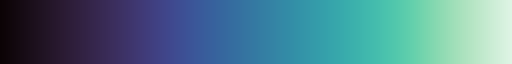

In [58]:
sns.color_palette("mako", as_cmap=True)

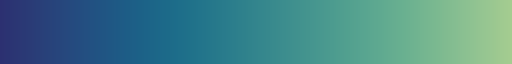

In [60]:
sns.color_palette("crest_r", as_cmap=True)

### Master DataFrame

In [3]:
master_df = pd.read_csv("data/2016_2021_master_df.csv")
master_df["DATE_PST"] = pd.to_datetime(master_df["DATE_PST"])
master_df.set_index("DATE_PST", inplace=True)
display(master_df.head())
print(master_df.shape)

,Vancouver_Clark_Drive_PM25,Vancouver_International_Airport_#2_PM25,North_Vancouver_Mahon_Park_PM25,North_Vancouver_Second_Narrows_PM25
DATE_PST,,,,
2016-01-01 01:00:00,30.557,22.71692,22.798870,NaN
2016-01-01 02:00:00,34.661,21.95020,22.909090,6.341111
2016-01-01 03:00:00,35.419,21.25953,19.857730,5.340278
2016-01-01 04:00:00,24.335,19.93333,13.575990,3.907917
2016-01-01 05:00:00,29.336,19.07922,7.079589,7.235889


(57014, 4)


In [4]:
# Datepart features
master_df['Month'] = master_df.index.month
master_df['Day_of_Week'] = master_df.index.day_name()
master_df['Hour'] = master_df.index.hour

master_df.iloc[:, 3:].head()

,North_Vancouver_Second_Narrows_PM25,Month,Day_of_Week,Hour
DATE_PST,,,,
2016-01-01 01:00:00,NaN,1,Friday,1
2016-01-01 02:00:00,6.341111,1,Friday,2
2016-01-01 03:00:00,5.340278,1,Friday,3
2016-01-01 04:00:00,3.907917,1,Friday,4
2016-01-01 05:00:00,7.235889,1,Friday,5


### Time Series Plot

In [5]:
# 24h Aggregating and melting
master_df_melt = pd.melt(master_df.resample("24H").mean(numeric_only=True),
                         value_vars=[
                            "Vancouver_Clark_Drive_PM25",\
                            "Vancouver_International_Airport_#2_PM25",\
                            "North_Vancouver_Mahon_Park_PM25",\
                            "North_Vancouver_Second_Narrows_PM25"
                            ],
                         ignore_index=False).rename(columns={
                            "variable": "Station",
                            "value": "PM 2.5"})
master_df_melt

,Station,PM 2.5
DATE_PST,,
2016-01-01,Vancouver_Clark_Drive_PM25,20.158652
2016-01-02,Vancouver_Clark_Drive_PM25,16.973417
2016-01-03,Vancouver_Clark_Drive_PM25,11.404792
2016-01-04,Vancouver_Clark_Drive_PM25,15.060409
2016-01-05,Vancouver_Clark_Drive_PM25,11.371000
...,...,...
2022-06-29,North_Vancouver_Second_Narrows_PM25,3.327361
2022-06-30,North_Vancouver_Second_Narrows_PM25,5.023754
2022-07-01,North_Vancouver_Second_Narrows_PM25,5.035238


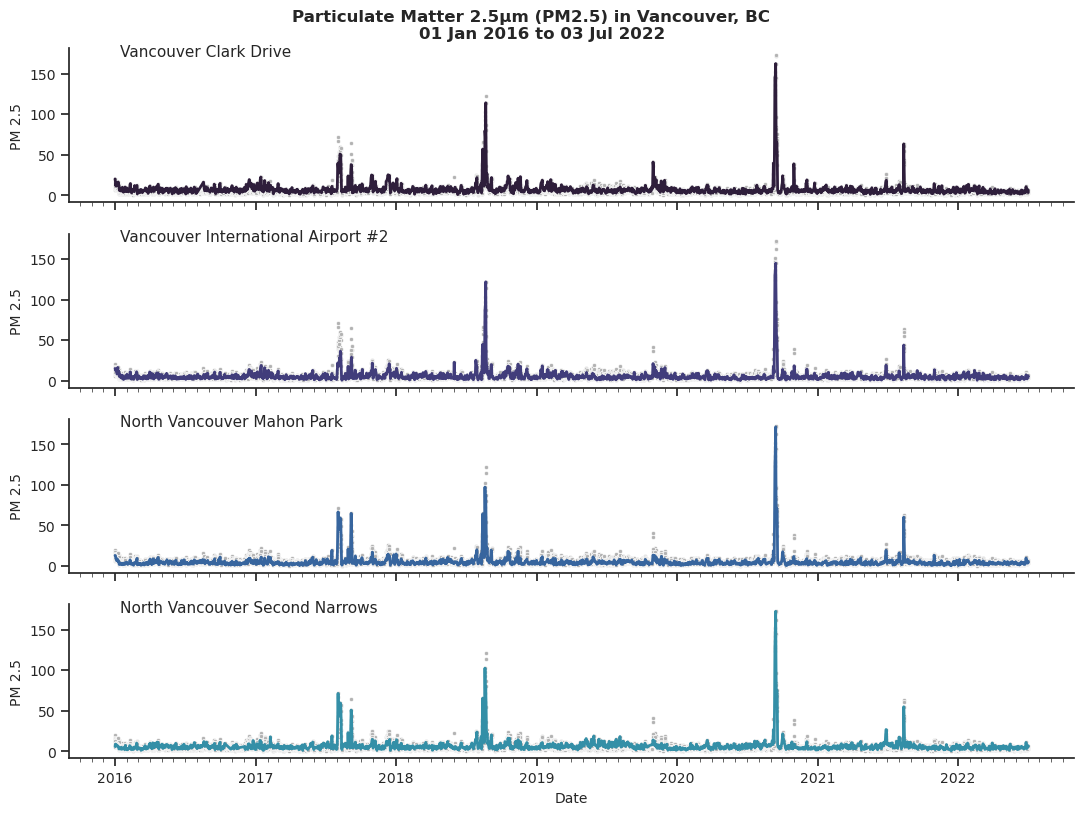

In [6]:
# Full time series plot from jan 2016 to jul 2022
rel = sns.relplot(master_df_melt,
                  x="DATE_PST",
                  y="PM 2.5",
                  col="Station",
                  hue="Station",
                  kind="line",
                  linewidth=2,
                  col_wrap=1,
                  height=2,
                  aspect=5.5,
                  zorder=5,
                  legend=False)

for station, ax in rel.axes_dict.items():
    ax.text(0.05, 0.95, station.replace('_', ' ')[:-4], transform=ax.transAxes, fontsize=11)
    sns.scatterplot(master_df_melt,
                 x="DATE_PST",
                 y="PM 2.5",
                 marker='.',
                 color=".7",
                 ax=ax)
    ax.set_ylabel("PM 2.5", fontsize=10)
    ax.xaxis.set_minor_locator(mdates.MonthLocator())
    ax.tick_params(which='major', labelsize=10)
    ax.tick_params(which='minor', length=3, width=0.5)
rel.set_titles("")
rel.tight_layout()
rel.set_xlabels("Date", fontsize=10)
plt.suptitle(f"Particulate Matter 2.5μm (PM2.5) in Vancouver, BC\
    \n{min(master_df_melt.index):%d %b %Y} to {max(master_df_melt.index):%d %b %Y}",
    y=1.02,
    fontsize=12,
    fontweight="bold")
plt.show()

Subsetting to an anomalous year at North Vancouver Mahon Park.

In [7]:
for step in range(datetime(2016, 1, 1).month, datetime(2019, 1, 1).month):
    print(step)

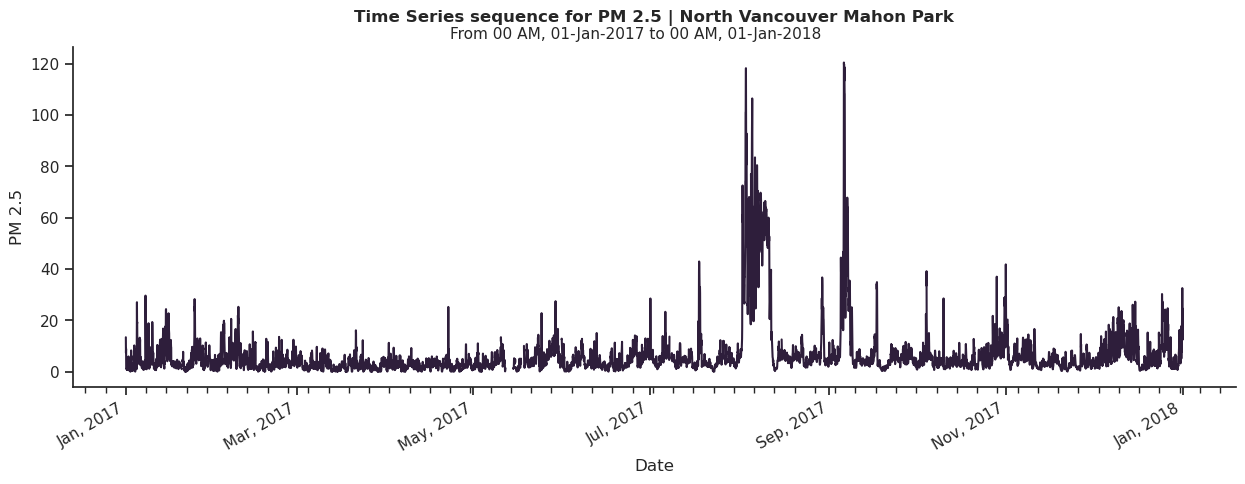

In [8]:
# Investigating smaller subsets
from tshelpers.plot import plot_sequence

plot_sequence(master_df,
              value="North_Vancouver_Mahon_Park_PM25",
              start=datetime(2017, 1, 1),
              end=datetime(2018, 1, 1),
              fill=False,
              plot_title="Time Series sequence for PM 2.5 | North Vancouver Mahon Park")

Subsetting to a seemingly calm year at North Vancouver Mahon Park.

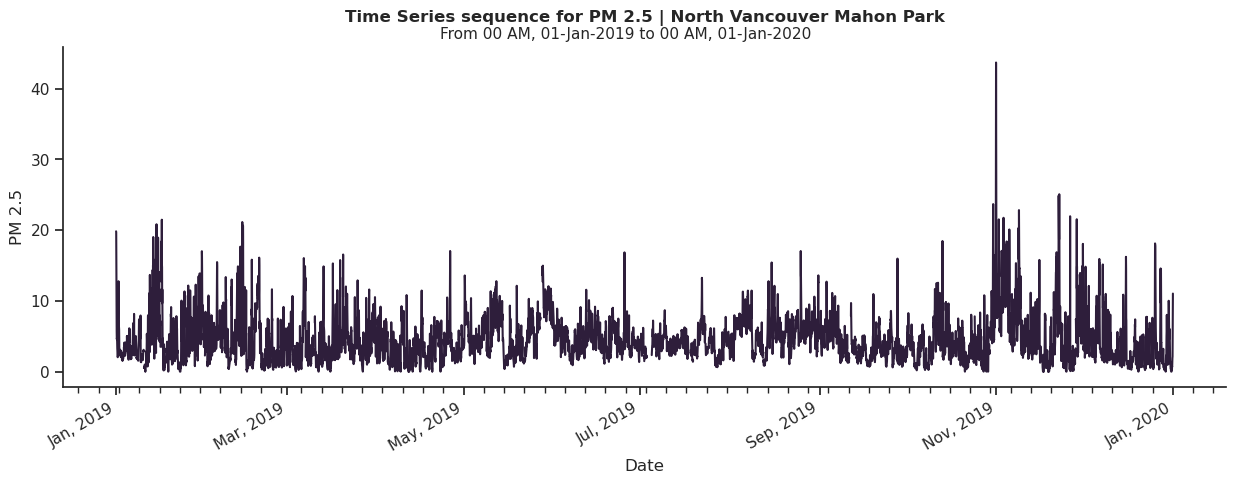

In [9]:
plot_sequence(master_df,
              value="North_Vancouver_Mahon_Park_PM25",
              start=datetime(2019, 1, 1),
              end=datetime(2020, 1, 1),
              fill=False,
              plot_title="Time Series sequence for PM 2.5 | North Vancouver Mahon Park")

### Summary Statistics

In [10]:
# Summary Statistics
master_df.iloc[:, :4].describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
Vancouver_Clark_Drive_PM25,55487.0,7.45,9.60,0.0,3.48,5.56,8.55,214.87
Vancouver_International_Airport_#2_PM25,56467.0,5.57,8.33,0.0,2.30,3.94,6.48,209.59
North_Vancouver_Mahon_Park_PM25,56381.0,5.11,8.98,0.0,2.04,3.51,5.67,203.03
North_Vancouver_Second_Narrows_PM25,54763.0,6.68,8.64,0.0,3.12,4.95,7.69,188.93


In [11]:
# Grouped Summary Statistics
# Monthly
master_df.drop(columns=['Hour']).groupby("Month").describe(percentiles=[]).T.round(2)

Month                                               1        2        3   \
Vancouver_Clark_Drive_PM25              count  4988.00  4708.00  5073.00   
                                        mean      7.82     7.05     6.00   
                                        std       6.11     5.28     4.18   
                                        min       0.23     0.00     0.00   
                                        50%       6.13     5.93     5.21   
                                        max      97.42    83.52   117.55   
Vancouver_International_Airport_#2_PM25 count  5151.00  4680.00  5168.00   
                                        mean      5.79     5.41     4.99   
                                        std       5.00     4.05     3.74   
                                        min       0.00     0.00     0.00   
                                        50%       4.24     4.48     4.03   
                                        max      34.39    48.08    42.16   
North_Vancouver_Mahon_Park_PM25         count  5183.00  4722.00  5158.00   
                                        mean      4.01     3.93     3.46   
                                        std       3.78     3.05     2.70   
                                        min       0.00     0.00     0.00   
                                        50%       2.87     3.12     2.77   
                                        max      35.20    25.27    22.39   
North_Vancouver_Second_Narrows_PM25     count  5135.00  4604.00  5166.00   
                                        mean      4.84     5.18     5.39   
                                        std       4.02     3.78     3.79   
                                        min       0.00     0.19     0.14   
                                        50%       3.72     4.21     4.38   
                                        max      47.73    40.56    37.21   

Month                                               4        5        6   \
Vancouver_Clark_Drive_PM25              count  4963.00  4912.00  4985.00   
                                        mean      5.66     5.60     5.28   
                                        std       3.90     3.38     3.53   
                                        min       0.00     0.00     0.00   
                                        50%       4.91     4.99     4.68   
                                        max      90.14    60.67    35.41   
Vancouver_International_Airport_#2_PM25 count  5024.00  5163.00  4985.00   
                                        mean      4.51     4.26     3.67   
                                        std       2.97     2.84     4.89   
                                        min       0.00     0.00     0.00   
                                        50%       3.85     3.71     3.05   
                                        max      22.56    27.05   209.59   
North_Vancouver_Mahon_Park_PM25         count  5010.00  5077.00  4982.00   
                                        mean      3.81     4.39     3.90   
                                        std       2.63     2.70     2.78   
                                        min       0.00     0.00     0.00   
                                        50%       3.22     3.83     3.32   
                                        max      25.22    30.32    38.38   
North_Vancouver_Second_Narrows_PM25     count  5018.00  4893.00  4965.00   
                                        mean      5.65     6.27     6.10   
                                        std       3.58     4.15     4.41   
                                        min       0.16     0.00     0.65   
                                        50%       4.76     5.27     5.08   
                                        max      37.82    29.71    45.78   

Month                                               7        8        9   \
Vancouver_Clark_Drive_PM25              count  4504.00  4039.00  4252.00   
                                        mean  

In [12]:
# Week-day
weekdays = master_df.index.day_name().unique().tolist()
weekdays = weekdays[2:] + weekdays[:2]
master_df.drop(columns=['Month', "Hour"]).groupby("Day_of_Week", sort=False).describe(percentiles=[]).T.round(2)[weekdays]

Day_of_Week                                     Sunday   Monday  Tuesday  \
Vancouver_Clark_Drive_PM25              count  7976.00  7883.00  7912.00   
                                        mean      6.77     7.49     7.67   
                                        std       9.97    11.18     8.64   
                                        min       0.00     0.00     0.00   
                                        50%       4.79     5.56     5.91   
                                        max     176.88   214.87   111.29   
Vancouver_International_Airport_#2_PM25 count  8097.00  8089.00  8055.00   
                                        mean      5.01     5.61     5.97   
                                        std       8.48     9.99     8.48   
                                        min       0.00     0.00     0.00   
                                        50%       3.51     3.82     4.26   
                                        max     148.82   177.53   123.40   
North_Vancouver_Mahon_Park_PM25         count  8105.00  8073.00  8053.00   
                                        mean      4.81     5.22     5.35   
                                        std       8.92    11.68     8.31   
                                        min       0.00     0.00     0.00   
                                        50%       3.36     3.44     3.66   
                                        max     154.92   203.03   106.10   
North_Vancouver_Second_Narrows_PM25     count  7858.00  7739.00  7782.00   
                                        mean      5.50     6.73     7.37   
                                        std       7.87     9.45     8.85   
                                        min       0.12     0.00     0.00   
                                        50%       4.21     5.01     5.48   
                                        max     157.46   188.93   137.92   

Day_of_Week                                    Wednesday  Thursday   Friday  \
Vancouver_Clark_Drive_PM25              count    7895.00   7925.00  7917.00   
                                        mean        7.94      7.66     7.67   
                                        std         9.43      8.43     8.64   
                                        min         0.00      0.00     0.00   
                                        50%         5.83      5.88     5.92   
                                        max       185.29    179.69   157.76   
Vancouver_International_Airport_#2_PM25 count    8038.00   8039.00  8041.00   
                                        mean        5.90      5.66     5.72   
                                        std         8.77      6.04     7.79   
                                        min         0.00      0.00     0.00   
                                        50%         4.14      4.21     4.04   
                                        max       165.28    123.56   209.59   
North_Vancouver_Mahon_Park_PM25         count    7978.00   8003.00  8065.00   
                                        mean        5.34      5.08     5.13   
                                        std         8.91      8.18     7.84   
                                        min         0.00      0.00     0.00   
                                        50%         3.59      3.50     3.54   
                                        max       145.74    152.77   133.11   
North_Vancouver_Second_Narrows_PM25     count    7814.00   7826.00  7861.00   
                                        mean        7.14      7.03     6.93   
                                        std         8.69      8.69     7.97   
                                        min         0.00      0.00     0.00   
                                        50%         5.14      5.21     5.19   
                                        max       140.95    154.72   122.78   

Day_of_Week                                    Saturday  
Vancouver_Clark_Drive_PM25              count   7979.00  
       

### Missing Values

In [13]:
from tshelpers.plot import plot_missing

# Missing Values summary
missing_tot = master_df.isna().sum()
missing_pct = round(master_df.isna().sum()/master_df.count()*100, 2)
missing_summary = pd.concat([missing_tot, missing_pct], axis=1)
missing_summary.rename(columns={0: 'Missing', 1: 'Missing %'})

,Missing,Missing %
Vancouver_Clark_Drive_PM25,1527,2.75
Vancouver_International_Airport_#2_PM25,547,0.97
North_Vancouver_Mahon_Park_PM25,633,1.12
North_Vancouver_Second_Narrows_PM25,2251,4.11
Month,0,0.00
Day_of_Week,0,0.00
Hour,0,0.00


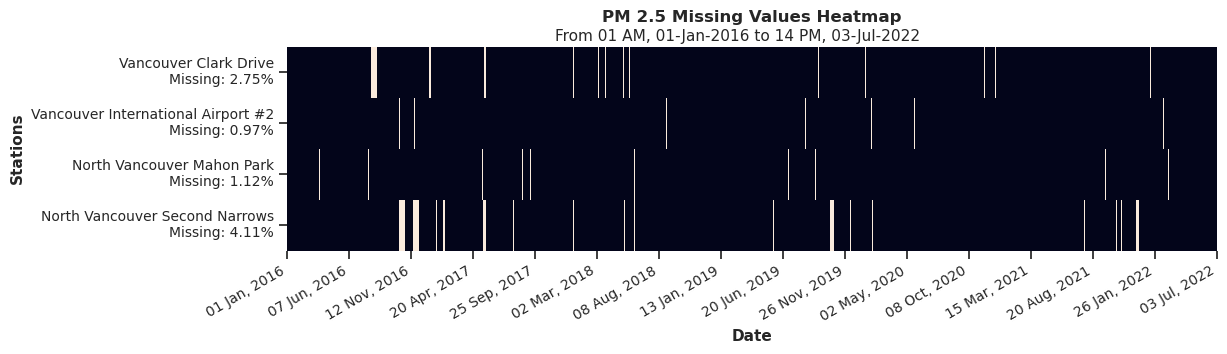

In [14]:
# Missing Values heatmap
plot_missing(master_df.iloc[:, :4])

### Seasonalities
An ehnanced view on the distribution of PM 2.5 values for each station for:
* Each hour of the day
* Each day of the week
* Each month of the year

The top 5% percentile will be removed to investigate possible trends without major outliers.


In [16]:
# Percentile cutoff
percentile = 0.95

# Subsets with top percentile cutoff
subsets = {}
for station in master_df.columns[:4]:
    subsets[station] = master_df[[station, 'Month', 'Day_of_Week', 'Hour']]
    subsets[station] = subsets[station][
        subsets[station][station] < subsets[station][station].quantile(percentile)
    ]

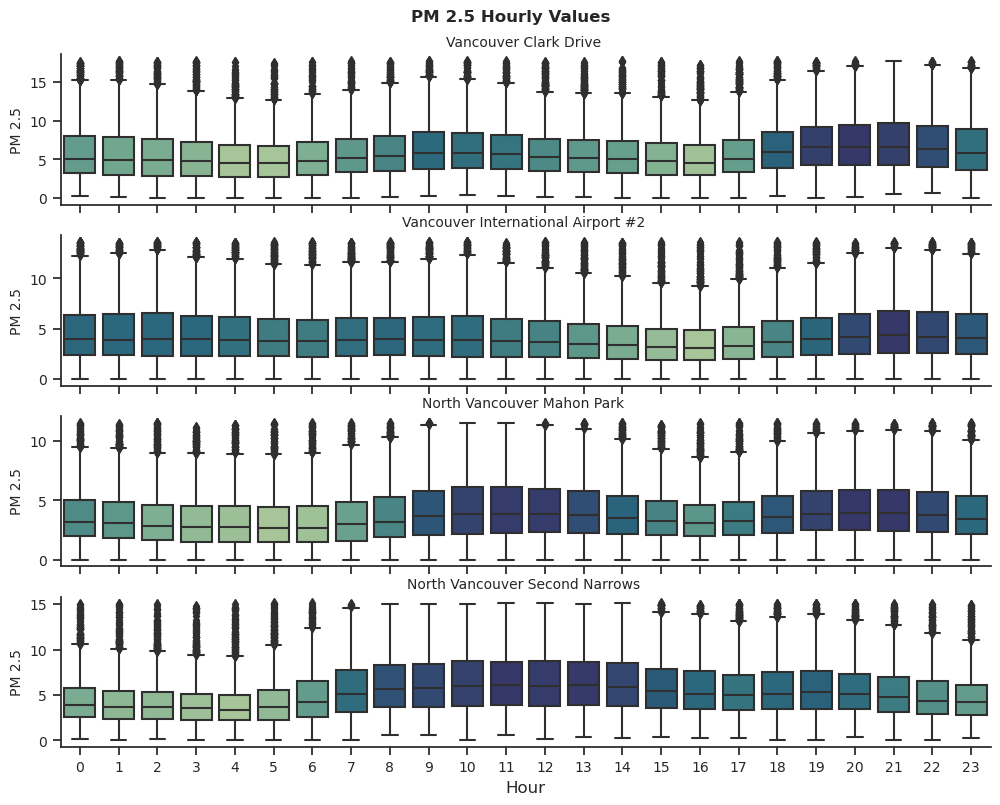

In [54]:
# Boxplots
def seasonal_plots(subsets,
                   interval='Hour',
                #    palette='mako',
                   figsize=(12, 9),
                   plot_title="",
                   xlabel="",
                   x_labelrotation=None):
    fig, ax = plt.subplots(4, 1, sharex=True, figsize=figsize)
    for i, station in enumerate(master_df.columns[:4]):
        if interval == 'Day_of_Week':
            order=["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"]
            median_vals = subsets[station].groupby(interval)[[station]].median().loc[order][station]
        else:
            order = None
            median_vals = subsets[station].groupby(interval)[station].median()
        norm = plt.Normalize(median_vals.min(), median_vals.max())
        palette = sns.cm.crest(norm(median_vals))
        b = sns.boxplot(ax=ax[i],
                    data=subsets[station],
                    x = interval,
                    y = station,
                    palette=palette,
                    order=order)
        ax[i].tick_params(axis='both', labelsize=10)
        ax[i].tick_params(axis='x', labelrotation=x_labelrotation)
        ax[i].set_title("")
        b.set_title(f"{station.replace('_', ' ')[:-4]}", fontsize=10)
        b.set_ylabel("PM 2.5", fontsize=10)
        b.set_xlabel("")
        sns.despine()
    plt.suptitle(plot_title, y=0.93, fontsize=12, fontweight="bold")
    plt.xlabel(xlabel)
    plt.show()

# Hourly plots
seasonal_plots(subsets,
               interval='Hour',
               plot_title="PM 2.5 Hourly Values",
               xlabel="Hour")

Consistently higher values for PM 2.5 from 9 AM to 2 PM. Stations outside North Vancouver also show a peak from 8 PM to 10 PM, while early mornings hold the lowest values for PM 2.5 from 2 AM to 5 AM.

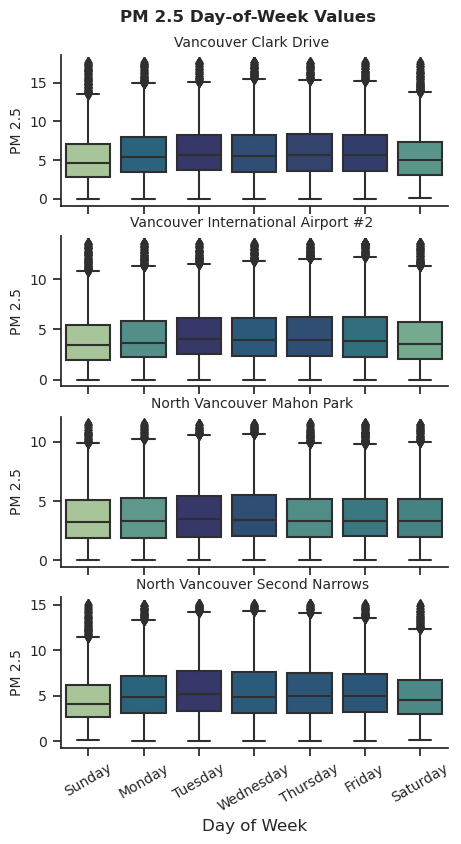

In [55]:
# Day-of-Week plots
seasonal_plots(subsets,
               interval='Day_of_Week',
               plot_title="PM 2.5 Day-of-Week Values",
               xlabel="Day of Week",
               figsize=(5, 9),
               x_labelrotation=30)

Lower PM 2.5 values during weekends, with a slightly higher trend for mid-week days.

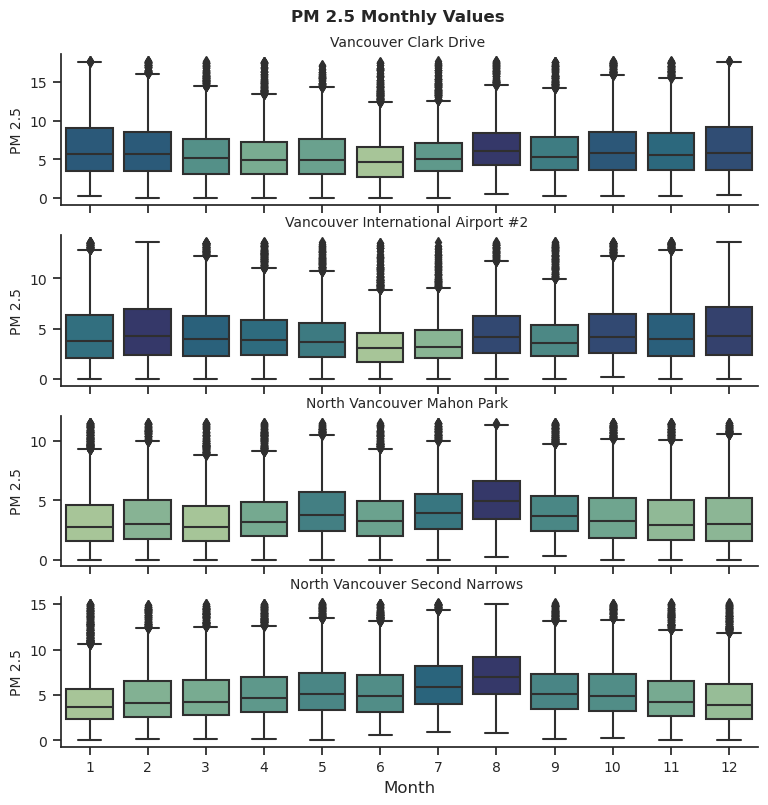

In [56]:
# Monthly plots
seasonal_plots(subsets,
               interval='Month',
               plot_title="PM 2.5 Monthly Values",
               xlabel="Month",
               figsize=(9, 9))

Consistently higher values for PM 2.5 in August for all years.

### Correlation

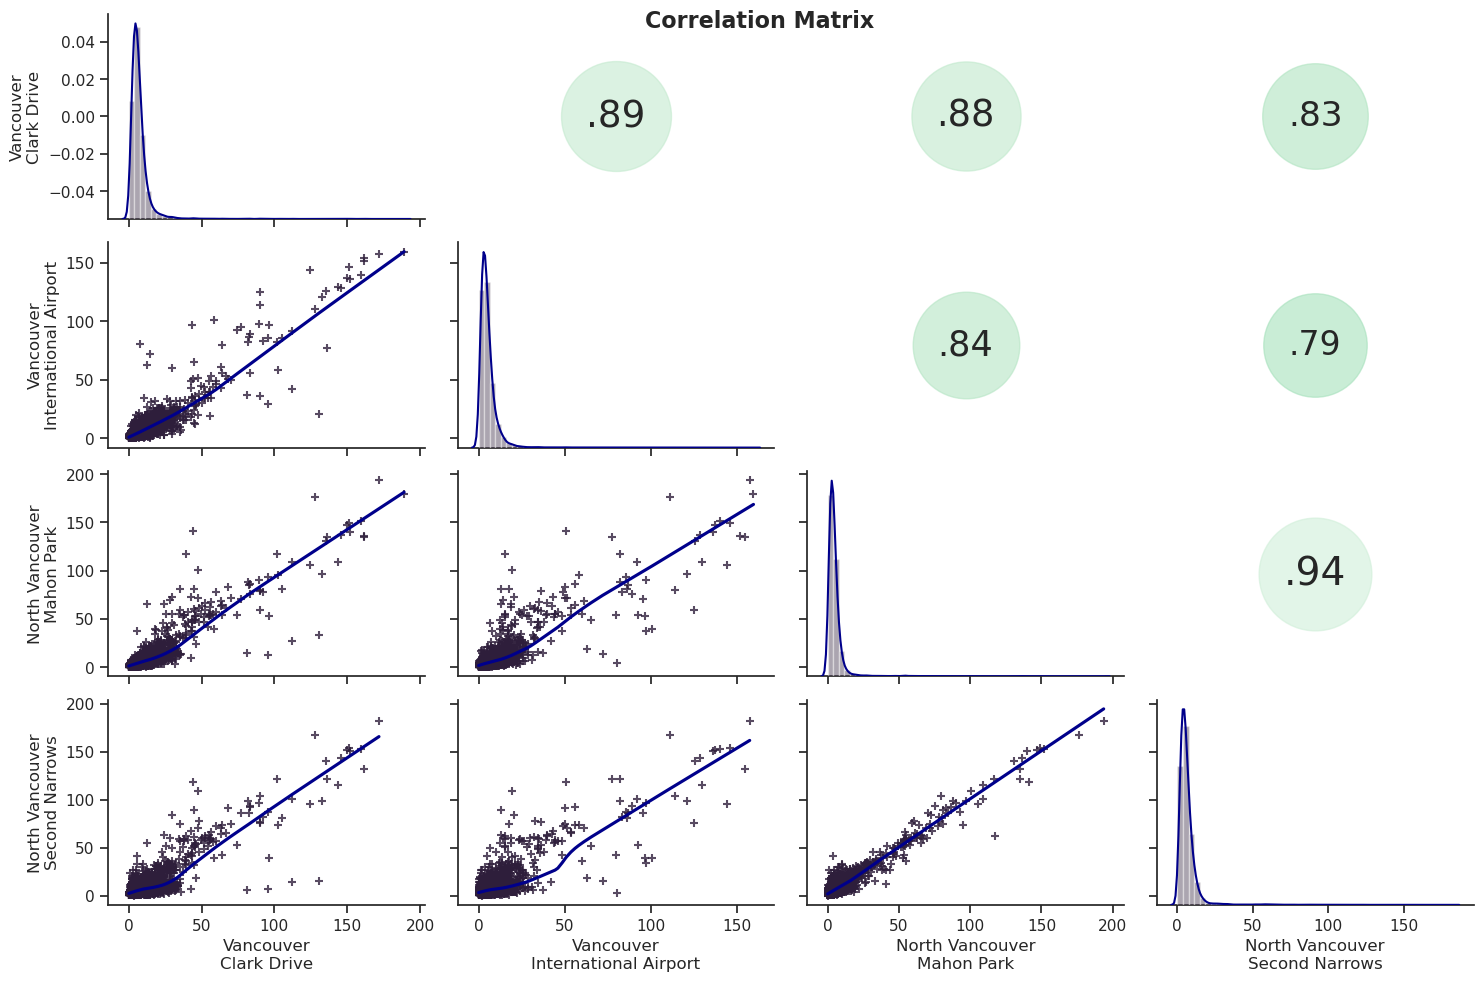

In [19]:
from tshelpers.plot import plot_correlation

# Aggregation
agg_rule = "6H"

master_df_agg = master_df.resample(agg_rule).mean(numeric_only=True)
master_df_agg.rename(columns={
    "Vancouver_Clark_Drive_PM25": "Vancouver\nClark Drive",
    "Vancouver_International_Airport_#2_PM25": "Vancouver\nInternational Airport",
    "North_Vancouver_Mahon_Park_PM25": "North Vancouver\nMahon Park",
    "North_Vancouver_Second_Narrows_PM25": "North Vancouver\nSecond Narrows"},
    inplace=True)

plot_correlation(master_df_agg, master_df_agg.iloc[:, :4].columns)

### Stationarity

In [20]:
# Augmented Dickey-Fuller (ADF) and Kwiatkowski-Phillips-Schmidt-Shin (KPSS) tests
from tshelpers.metrics import stationarity_test

help(stationarity_test)

Help on function stationarity_test in module tshelpers.metrics:

stationarity_test(data, value, time=None, start=None, end=None, fillna='interpolate', dropna=True, autolag='AIC')
    Perform and return results for "ADF" and "KPSS" stationarity tests.
    
    Augmented Dickey-Fuller (ADF) test hypothesis:
    H0: A unit root is present in the time series sample (Non-stationary)
    Ha: There is no root unit present in the time series sample (Stationary)
    
    Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test hypothesis:
    H0: The data is stationary around a constant (Stationary)
    Ha: A unit root is present in the time series sample (Non-stationary)
    
    output: Output dict of a statsmodels adfuller or kpss test.
    test: Either 'adf' or 'kpss' to define decision based on p-value.
    
    data: Pandas DataFrame with a time series and a value column.
    start: Start date for interval.
    end: End date for interval.
    fillna: ["interpolate", "ffill", "bfill"] method to fill 

In [21]:
# Stationarity in Jan 2016 for all stations
for station in master_df.columns[:4]:
    print(f"{station}:")
    display(
        stationarity_test(master_df,
                    value=station,
                    start=datetime(2016, 1, 1, 1),
                    end=datetime(2016, 2, 1))
            )

Vancouver_Clark_Drive_PM25:


,adf,kpss
Test Statistic,-3.164,2.5345
p-value,0.0222,0.01
Lags Used,20,15
Decision,Stationary,Non-Stationary


Vancouver_International_Airport_#2_PM25:


,adf,kpss
Test Statistic,-2.7768,3.079
p-value,0.0617,0.01
Lags Used,20,15
Decision,Non-Stationary,Non-Stationary


North_Vancouver_Mahon_Park_PM25:


,adf,kpss
Test Statistic,-3.2545,2.6203
p-value,0.017,0.01
Lags Used,20,15
Decision,Stationary,Non-Stationary


North_Vancouver_Second_Narrows_PM25:


,adf,kpss
Test Statistic,-3.77,1.6923
p-value,0.0032,0.01
Lags Used,17,15
Decision,Stationary,Non-Stationary


In [22]:
# Stationarity in Jan 2022 for all stations
for station in master_df.columns[:4]:
    print(f"{station}:")
    display(
        stationarity_test(master_df,
                    value=station,
                    start=datetime(2022, 1, 1),
                    end=datetime(2022, 2, 1),
                    autolag="t-stat")
            )

Vancouver_Clark_Drive_PM25:


,adf,kpss
Test Statistic,-4.8994,0.8963
p-value,0.0,0.01
Lags Used,12,14
Decision,Stationary,Non-Stationary


Vancouver_International_Airport_#2_PM25:


,adf,kpss
Test Statistic,-3.2505,0.4676
p-value,0.0172,0.049
Lags Used,20,15
Decision,Stationary,Non-Stationary


North_Vancouver_Mahon_Park_PM25:


,adf,kpss
Test Statistic,-3.7076,1.4438
p-value,0.004,0.01
Lags Used,20,15
Decision,Stationary,Non-Stationary


North_Vancouver_Second_Narrows_PM25:


,adf,kpss
Test Statistic,-3.8819,0.6887
p-value,0.0022,0.0146
Lags Used,19,15
Decision,Stationary,Non-Stationary


In [23]:
# Stationarity in 2016 for all stations
for station in master_df.columns[:4]:
    print(f"{station}:")
    display(
        stationarity_test(master_df,
                    value=station,
                    start=datetime(2016, 1, 1, 1),
                    end=datetime(2017, 2, 1))
            )

Vancouver_Clark_Drive_PM25:


,adf,kpss
Test Statistic,-9.9507,1.2208
p-value,0.0,0.01
Lags Used,30,49
Decision,Stationary,Non-Stationary


Vancouver_International_Airport_#2_PM25:


,adf,kpss
Test Statistic,-9.458,1.1197
p-value,0.0,0.01
Lags Used,34,52
Decision,Stationary,Non-Stationary


North_Vancouver_Mahon_Park_PM25:


,adf,kpss
Test Statistic,-10.9598,0.2028
p-value,0.0,0.1
Lags Used,25,49
Decision,Stationary,Stationary


North_Vancouver_Second_Narrows_PM25:


,adf,kpss
Test Statistic,-10.1818,1.3322
p-value,0.0,0.01
Lags Used,27,49
Decision,Stationary,Non-Stationary


In [24]:
# Stationarity in 2021 for all stations
for station in master_df.columns[:4]:
    print(f"{station}:")
    display(
        stationarity_test(master_df,
                    value=station,
                    start=datetime(2021, 1, 1, 1),
                    end=datetime(2022, 1, 1))
            )

Vancouver_Clark_Drive_PM25:


,adf,kpss
Test Statistic,-11.8065,0.0947
p-value,0.0,0.1
Lags Used,36,52
Decision,Stationary,Stationary


Vancouver_International_Airport_#2_PM25:


,adf,kpss
Test Statistic,-12.1242,0.0943
p-value,0.0,0.1
Lags Used,29,51
Decision,Stationary,Stationary


North_Vancouver_Mahon_Park_PM25:


,adf,kpss
Test Statistic,-11.0524,0.385
p-value,0.0,0.0836
Lags Used,32,53
Decision,Stationary,Stationary


North_Vancouver_Second_Narrows_PM25:


,adf,kpss
Test Statistic,-10.0548,0.8058
p-value,0.0,0.01
Lags Used,34,53
Decision,Stationary,Non-Stationary


Results interpretation:

>* Case 1: Both tests conclude that the series is not stationary - The series is not stationary
>* Case 2: Both tests conclude that the series is stationary - The series is stationary
>* Case 3: KPSS indicates stationarity and ADF indicates non-stationarity - The series is trend stationary. Trend needs to be removed to make series strict stationary. The detrended series is checked for stationarity.
>* Case 4: KPSS indicates non-stationarity and ADF indicates stationarity - The series is difference stationary. Differencing is to be used to make series stationary. The differenced series is checked for stationarity.

_source: https://www.statsmodels.org/dev/examples/notebooks/generated/stationarity_detrending_adf_kpss.html_

Case 4 seems predominant in our results, indicating that first-order differenting might be apropriate to our data.

### First-order Differenting

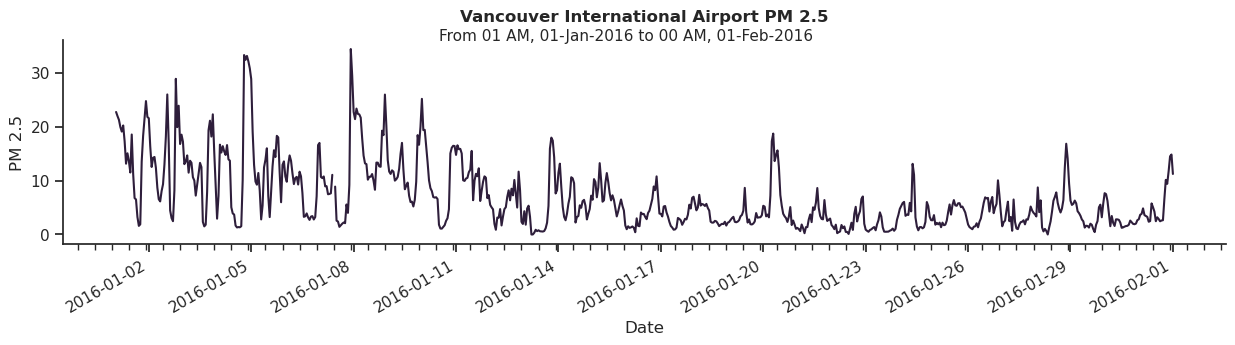

In [25]:
plot_sequence(master_df,
              value="Vancouver_International_Airport_#2_PM25",
              start=datetime(2016, 1, 1),
              end=datetime(2016, 2, 1),
              plot_title="Vancouver International Airport PM 2.5",
              figsize=(15,3),
              fill=False)

In [26]:
stationarity_test(master_df,
                  value="Vancouver_International_Airport_#2_PM25",
                  start=datetime(2016, 1, 1),
                  end=datetime(2016, 2, 1))

,adf,kpss
Test Statistic,-2.7768,3.079
p-value,0.0617,0.01
Lags Used,20,15
Decision,Non-Stationary,Non-Stationary


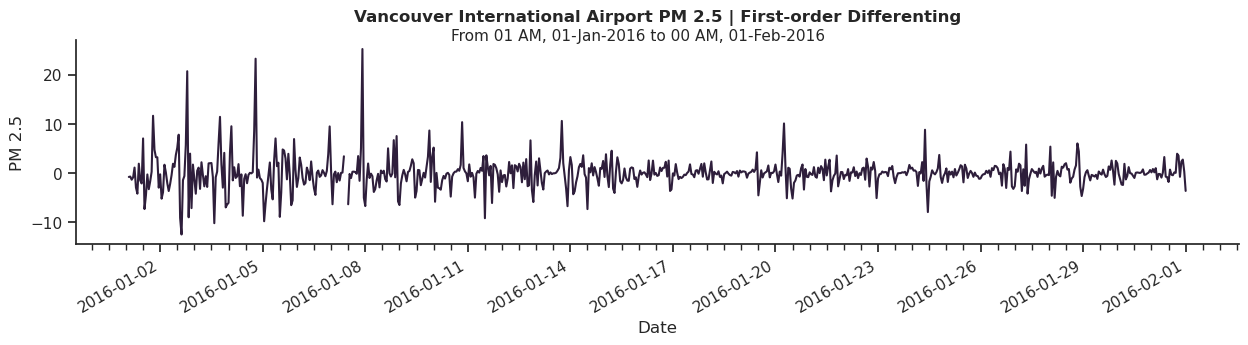

In [27]:
# First-order differenting example
master_df_diff1 = master_df.iloc[:, :4].diff()

plot_sequence(master_df_diff1,
              value="Vancouver_International_Airport_#2_PM25",
              start=datetime(2016, 1, 1),
              end=datetime(2016, 2, 1),
              plot_title="Vancouver International Airport PM 2.5 | First-order Differenting",
              figsize=(15,3),
              fill=False)

In [28]:
stationarity_test(master_df_diff1,
                  value="Vancouver_International_Airport_#2_PM25",
                  start=datetime(2016, 1, 1),
                  end=datetime(2016, 2, 1))

,adf,kpss
Test Statistic,-12.153,0.1035
p-value,0.0,0.1
Lags Used,20,24
Decision,Stationary,Stationary


### Autocorrelation and Partial Autocorrelation

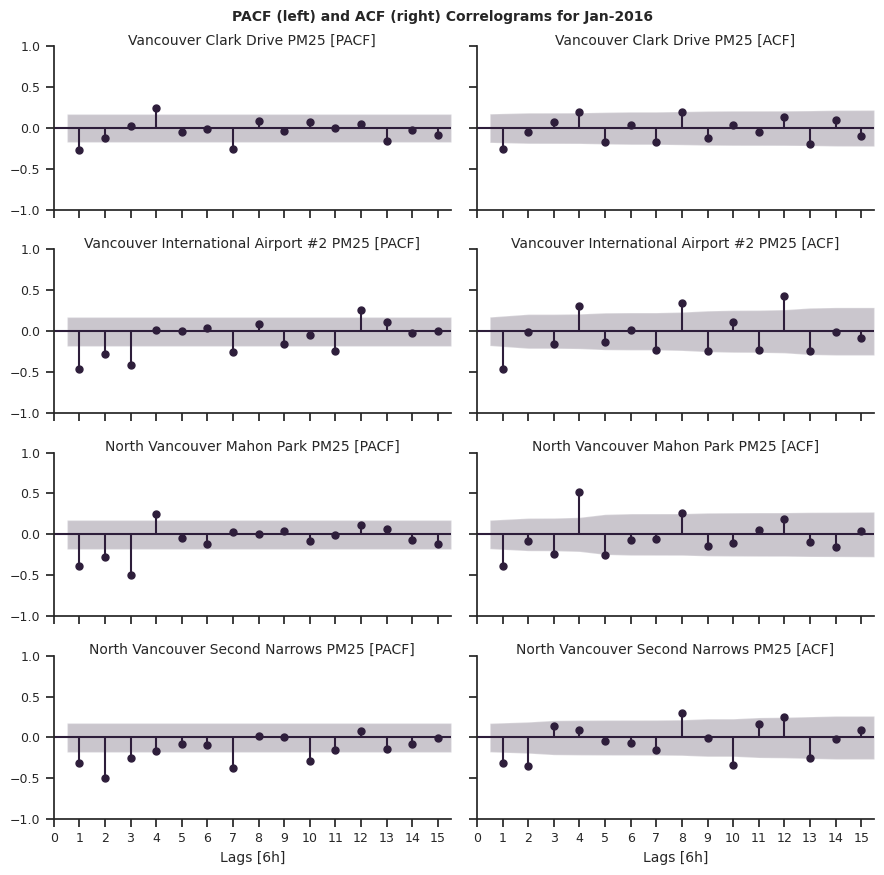

In [29]:
# Multiple PACF and ACF Correlograms
from tshelpers.plot import plot_multiple_pacf

# Aggregation and Forward Fill
agg_rule = "6H"
master_df_dff1_agg = master_df_diff1.resample(agg_rule).mean(numeric_only=True).interpolate()

# Correlograms for January 2016
plot_multiple_pacf(master_df_dff1_agg,
                   master_df_dff1_agg.columns,
                   start=datetime(2016, 1, 1),
                   end=datetime(2016, 2, 1),
                   plot_title="PACF (left) and ACF (right) Correlograms for Jan-2016",
                   x_label="Lags [6h]")

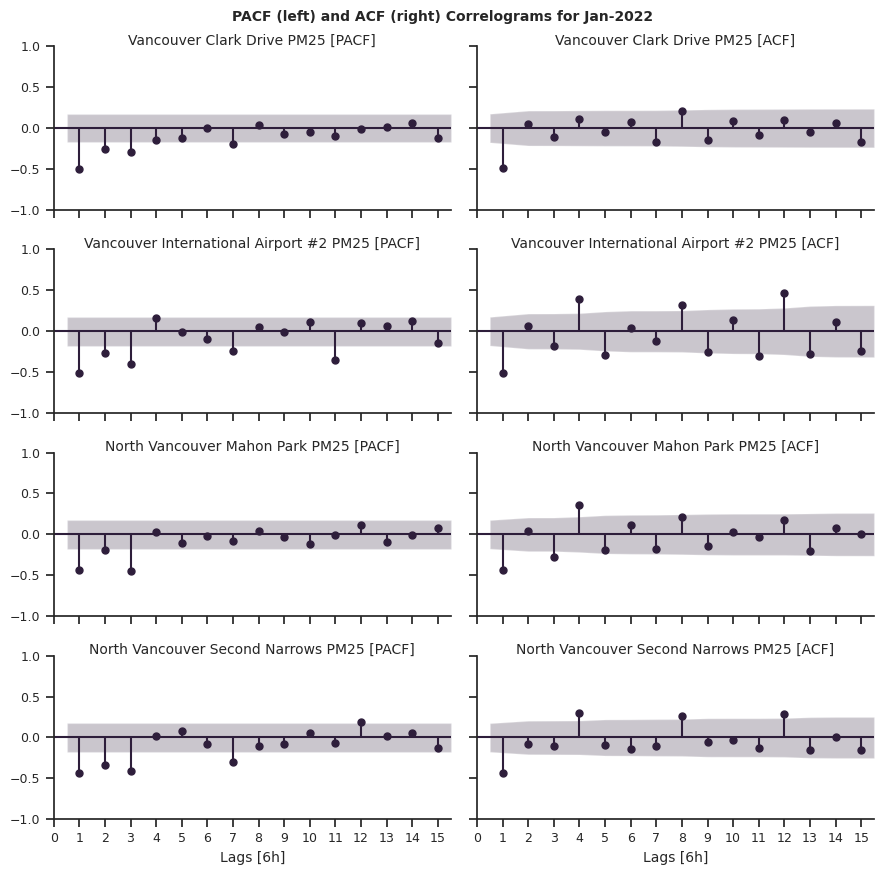

In [30]:
# Correlograms for January 2022
plot_multiple_pacf(master_df_dff1_agg,
                   master_df_dff1_agg.columns,
                   start=datetime(2022, 1, 1),
                   end=datetime(2022, 2, 1),
                   plot_title="PACF (left) and ACF (right) Correlograms for Jan-2022",
                   x_label="Lags [6h]")

On a 6h aggregation, it seems that lags 1, 2, 3, and 4 (t-6h, t-12h, t-18h, and t-24h) shows significant PACF and ACF.

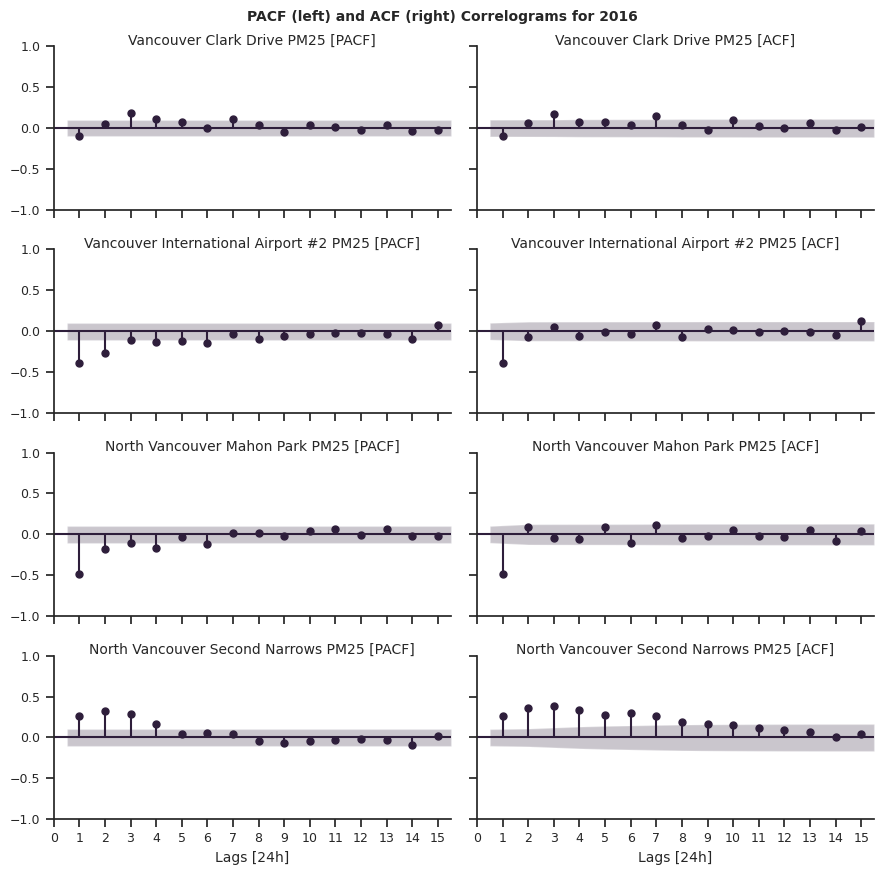

In [31]:
# Correlograms for 2016
# 24h Aggregation and Forward Fill
agg_rule = "24H"
master_df_dff1_agg = master_df_diff1.resample(agg_rule).mean(numeric_only=True).interpolate()

plot_multiple_pacf(master_df_dff1_agg,
                   master_df_dff1_agg.columns,
                   start=datetime(2016, 1, 1),
                   end=datetime(2017, 1, 1),
                   plot_title="PACF (left) and ACF (right) Correlograms for 2016",
                   x_label="Lags [24h]")

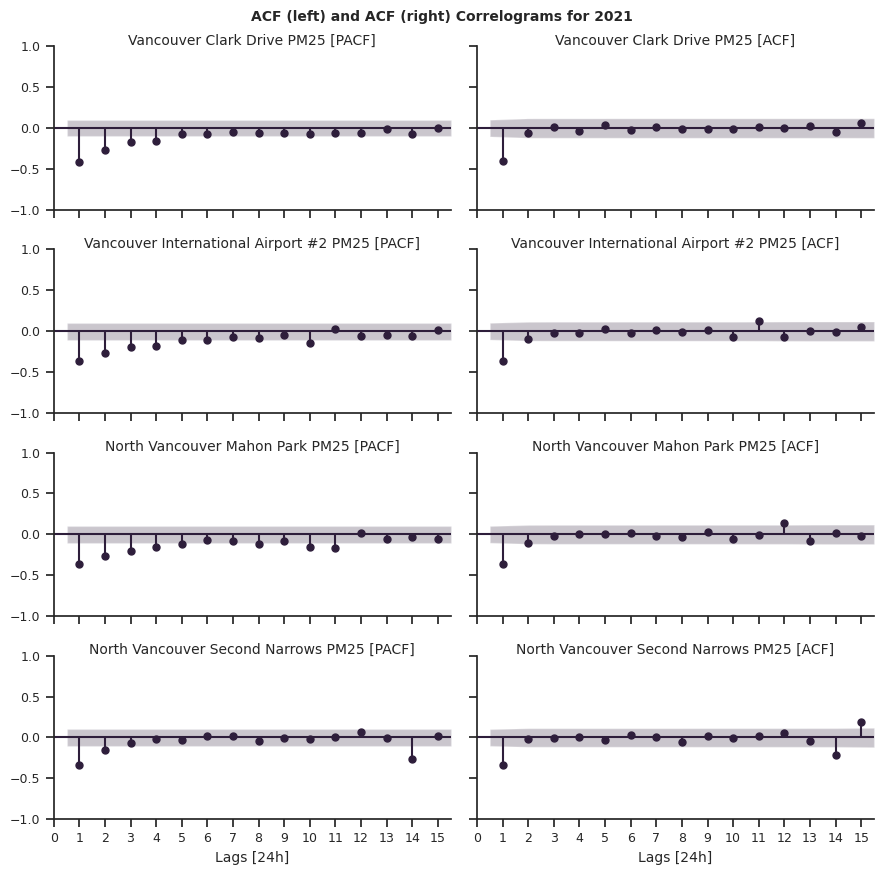

In [32]:
# Correlograms for 2021
plot_multiple_pacf(master_df_dff1_agg,
                   master_df_dff1_agg.columns,
                   start=datetime(2021, 1, 1),
                   end=datetime(2022, 1, 1),
                   plot_title="ACF (left) and ACF (right) Correlograms for 2021",
                   x_label="Lags [24h]")

On a 24h aggregation, it seems that the last 3 to 4 lags (72h to 96h) shows significant PACF. Only the last day shows significant ACF.

### Anomaly Detection